### Chooose high volume, high activity stocks like historically high volume, premarket movers, tech sectors
### Define breakout rule: price breaching 20 period rolling max/min price and volume breaching rolling max volume
### Based on the signal go long/short
### Define exit/stop loss signal: previous plus/minus 20 period ATR as the rolling stop loss price
### Backtest the strategy by calculating cumulative return for each stock

In [30]:
import numpy as np
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import copy
import time
import datetime as dt
import yfinance as yf

In [31]:
def CAGR(DF):
    df=DF.copy()
    #df["return"]=df["Adj Close"].pct_change()
    df["cum_return"]=(1+df["ret"]).cumprod()
    n=len(df)/(252*78) #252 trading days #252*6.5 trading hours #252*6.5*12 (5mins)
    CAGR=(df["cum_return"][-1])**(1/n) -1
    return CAGR

In [32]:
def volatility(DF):
    df=DF.copy()
    #df["return"]=df["Adj Close"].pct_change()
    vol=df["ret"].std()*np.sqrt(252*78)  #252 as it is day candle stick #52 if it is week candle stick
    return vol

In [33]:
def sharpe(DF,rf):
    df=DF.copy()
    return ((CAGR(df)-rf)/volatility(df))

In [34]:
def max_dd(DF):
    df=DF.copy()
    #df["return"]=df["Adj Close"].pct_change()
    df["cum_return"]=(1+df["ret"]).cumprod()
    df["cum_roll_max"]=df["cum_return"].cummax()
    df["drawdown"]=df["cum_roll_max"]-df["cum_return"]
    df["drawdown_pct"]=df["drawdown"]/df["cum_roll_max"]
    return df["drawdown_pct"].max()

In [35]:
def ATR(DF,n=14):
    df=DF.copy()
    df["H-L"]=df["High"]-df["Low"]
    df["H-PC"]=df["High"]-df["Adj Close"].shift(1)
    df["L-PC"]=df["Low"]-df["Adj Close"].shift(1)
    df["TR"]=df[["H-L","H-PC","L-PC"]].max(axis=1,skipna=False)
    df["ATR"]=df["TR"].ewm(com=n,min_periods=n).mean()
    return df["ATR"]

In [36]:
 tickers=["MSFT","AAPL","META","AMZN","INTC", "CSCO","VZ","IBM","TSLA","AMD"]

In [37]:
ohlc_intra={} #directory with ohlc value for each stock
start=dt.datetime.today()-dt.timedelta(days=7)
end=dt.datetime.today()

for ticker in tickers:
    ohlc_intra[ticker]=yf.download(ticker,start=start,end=end,interval='1m')
    ohlc_intra[ticker].dropna(inplace=True,how="all")

tickers=ohlc_intra.keys()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [38]:
ohlc_intra

{'MSFT':                                  Open        High         Low       Close  \
 Datetime                                                                    
 2022-10-18 14:50:00-04:00  236.970001  236.970001  236.710007  236.779999   
 2022-10-18 14:51:00-04:00  236.770004  237.089996  236.690002  236.929993   
 2022-10-18 14:52:00-04:00  236.910004  237.320007  236.800003  237.179993   
 2022-10-18 14:53:00-04:00  237.250000  237.529999  237.110001  237.509995   
 2022-10-18 14:54:00-04:00  237.460007  237.490005  237.255005  237.490005   
 ...                               ...         ...         ...         ...   
 2022-10-25 14:45:00-04:00  249.639999  249.639999  249.419998  249.531006   
 2022-10-25 14:46:00-04:00  249.522400  249.539993  249.393097  249.500000   
 2022-10-25 14:47:00-04:00  249.479996  249.479996  249.229996  249.289993   
 2022-10-25 14:48:00-04:00  249.279999  249.339996  249.250000  249.300003   
 2022-10-25 14:49:59-04:00  249.309998  249.309998  249.

# calculating ATR and rolling max price for each stock and consolidating this info by stock in a seperate dataframe

In [39]:
ohlc_dict=copy.deepcopy(ohlc_intra)
tickers_signal={}
tickers_ret={}
for ticker in tickers:
    print("calculating ATR and rolling max price for",ticker)
    ohlc_dict[ticker]["ATR"]=ATR(ohlc_dict[ticker],20)
    ohlc_dict[ticker]["roll_max_cp"]=ohlc_dict[ticker]["High"].rolling(20).max()
    ohlc_dict[ticker]["roll_min_cp"]=ohlc_dict[ticker]["Low"].rolling(20).min()
    ohlc_dict[ticker]["roll_max_vol"]=ohlc_dict[ticker]["Volume"].rolling(20).max()
    ohlc_dict[ticker].dropna(inplace=True)
    tickers_signal[ticker]=""
    tickers_ret[ticker]=[0]

calculating ATR and rolling max price for MSFT
calculating ATR and rolling max price for AAPL
calculating ATR and rolling max price for META
calculating ATR and rolling max price for AMZN
calculating ATR and rolling max price for INTC
calculating ATR and rolling max price for CSCO
calculating ATR and rolling max price for VZ
calculating ATR and rolling max price for IBM
calculating ATR and rolling max price for TSLA
calculating ATR and rolling max price for AMD


In [40]:
ohlc_dict.keys()

dict_keys(['MSFT', 'AAPL', 'META', 'AMZN', 'INTC', 'CSCO', 'VZ', 'IBM', 'TSLA', 'AMD'])

ohlc_dict["MSFT"]['2022-08-02'][0:25]

In [41]:
!pip install mplfinance

In [42]:
import mplfinance as mpf

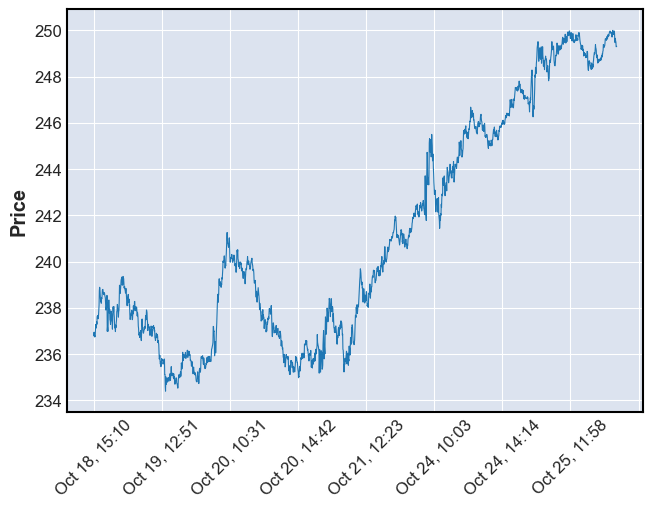

In [43]:
mpf.plot(data=ohlc_dict["MSFT"],type='line',volume=False,show_nontrading=False)

/Users/bikenkc/opt/anaconda3/lib/python3.9/site-packages/mplfinance/_arg_validators.py:36: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


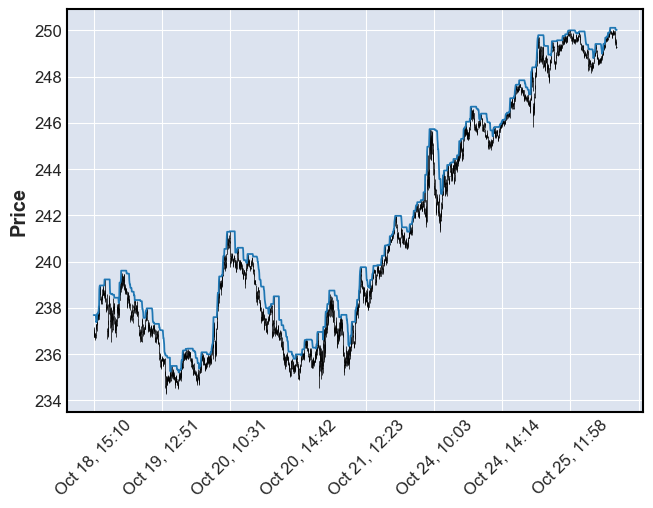

In [44]:
roll_max_plot=mpf.make_addplot(ohlc_dict["MSFT"]["roll_max_cp"])
mpf.plot(data=ohlc_dict["MSFT"],addplot=roll_max_plot)

/Users/bikenkc/opt/anaconda3/lib/python3.9/site-packages/mplfinance/_arg_validators.py:36: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


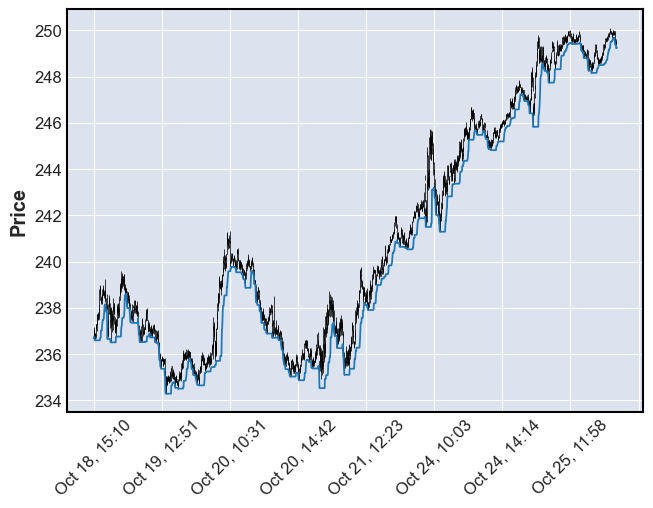

In [45]:
roll_min_plot=mpf.make_addplot(ohlc_dict["MSFT"]["roll_min_cp"])
mpf.plot(data=ohlc_dict["MSFT"],addplot=roll_min_plot)

In [46]:
tickers_signal

{'MSFT': '',
 'AAPL': '',
 'META': '',
 'AMZN': '',
 'INTC': '',
 'CSCO': '',
 'VZ': '',
 'IBM': '',
 'TSLA': '',
 'AMD': ''}

In [47]:
tickers_ret

{'MSFT': [0],
 'AAPL': [0],
 'META': [0],
 'AMZN': [0],
 'INTC': [0],
 'CSCO': [0],
 'VZ': [0],
 'IBM': [0],
 'TSLA': [0],
 'AMD': [0]}

In [48]:
ohlc_dict["MSFT"][0:5]

,Open,High,Low,Close,Adj Close,Volume,ATR,roll_max_cp,roll_min_cp,roll_max_vol
Datetime,,,,,,,,,,
2022-10-18 15:10:00-04:00,236.959900,237.179993,236.779999,236.800003,236.800003,30848,0.339599,237.690002,236.690002,79973.0
2022-10-18 15:11:00-04:00,236.750000,237.085007,236.740005,236.933594,236.933594,30068,0.340001,237.690002,236.740005,79973.0
2022-10-18 15:12:00-04:00,236.932297,237.000000,236.800003,236.949997,236.949997,27067,0.329871,237.690002,236.740005,79973.0
2022-10-18 15:13:00-04:00,236.940002,236.940002,236.720001,236.750000,236.750000,31871,0.322113,237.690002,236.720001,66763.0
2022-10-18 15:14:00-04:00,236.740005,236.800003,236.600006,236.800003,236.800003,35066,0.313685,237.690002,236.600006,66763.0


In [49]:
# identifying signals and calculating daily return (stop loss factored in)
for ticker in tickers:
    print("calculating returns for ",ticker)
    for i in range(1,len(ohlc_dict[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
        
        elif tickers_signal[ticker] == "Buy":
            if ohlc_dict[ticker]["Low"][i]<ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1]:   #change of direction
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append(((ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1])/ohlc_dict[ticker]["Close"][i-1])-1)
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
                
        elif tickers_signal[ticker] == "Sell":
            if ohlc_dict[ticker]["High"][i]>ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]:  #change of direction
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/(ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]))-1)
            elif ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
                
    ohlc_dict[ticker]["ret"] = np.array(tickers_ret[ticker])

calculating returns for  MSFT
calculating returns for  AAPL
calculating returns for  META
calculating returns for  AMZN
calculating returns for  INTC
calculating returns for  CSCO
calculating returns for  VZ
calculating returns for  IBM
calculating returns for  TSLA
calculating returns for  AMD


In [50]:
print(ohlc_dict["MSFT"])

                                 Open        High         Low       Close  \
Datetime                                                                    
2022-10-18 15:10:00-04:00  236.959900  237.179993  236.779999  236.800003   
2022-10-18 15:11:00-04:00  236.750000  237.085007  236.740005  236.933594   
2022-10-18 15:12:00-04:00  236.932297  237.000000  236.800003  236.949997   
2022-10-18 15:13:00-04:00  236.940002  236.940002  236.720001  236.750000   
2022-10-18 15:14:00-04:00  236.740005  236.800003  236.600006  236.800003   
...                               ...         ...         ...         ...   
2022-10-25 14:45:00-04:00  249.639999  249.639999  249.419998  249.531006   
2022-10-25 14:46:00-04:00  249.522400  249.539993  249.393097  249.500000   
2022-10-25 14:47:00-04:00  249.479996  249.479996  249.229996  249.289993   
2022-10-25 14:48:00-04:00  249.279999  249.339996  249.250000  249.300003   
2022-10-25 14:49:59-04:00  249.309998  249.309998  249.309998  249.309998   

In [51]:
#calculating overall strategy's KPIs
strategy_df=pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker]=ohlc_dict[ticker]["ret"]
strategy_df["ret"]=strategy_df.mean(axis=1)
print(CAGR(strategy_df))
print(sharpe(strategy_df,0.025))
print(max_dd(strategy_df))

0.13147254756187476
3.2350470966173335
0.003275535027056278


<AxesSubplot:xlabel='Datetime'>

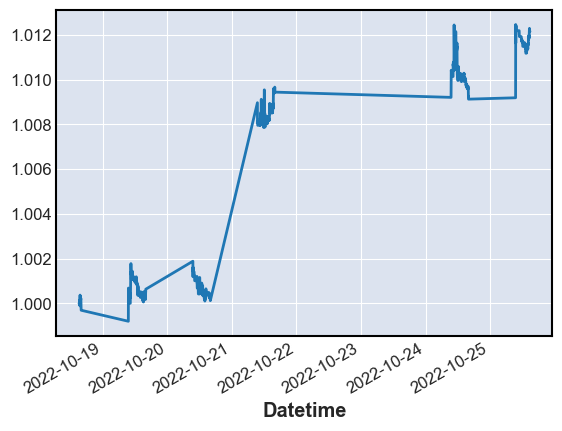

In [52]:
(1+strategy_df["ret"]).cumprod().plot()

In [53]:
#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_dict[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_dict[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_dict[ticker])

calculating KPIs for  MSFT
calculating KPIs for  AAPL
calculating KPIs for  META
calculating KPIs for  AMZN
calculating KPIs for  INTC
calculating KPIs for  CSCO
calculating KPIs for  VZ
calculating KPIs for  IBM
calculating KPIs for  TSLA
calculating KPIs for  AMD


In [54]:
KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

,Return,Sharpe Ratio,Max Drawdown
MSFT,-0.078873,-4.457443,0.009035
AAPL,-0.103102,-5.862458,0.012797
META,0.730318,5.231841,0.018713
AMZN,-0.050716,-3.434099,0.009506
INTC,0.010981,-0.306956,0.011638
CSCO,0.047823,0.945725,0.005331
VZ,0.678203,3.867626,0.008737
IBM,-0.105815,-6.278589,0.013164
TSLA,0.114485,1.652066,0.010185
AMD,0.397943,5.326524,0.010111
